In [ ]:
#| include: false
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import glob
import warnings

import pdb

import numpy as np

from pygengraph.graph import GenomeGraph
from pygengraph.graph import initialPathAnalysis,calcNodeLengths,getNodesStructurePathNodeInversionRate,pathNodeDirToCombinedArray,getNextNodePath
from pygengraph.graph import convertPathsToGraph

import networkx as nx

In [ ]:
from nbdev import nbdev_export
nbdev_export()

In [ ]:
warnings.filterwarnings("ignore")

### code profiling help

https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html

`%time`: Time the execution of a single statement  
`%timeit`: Time repeated execution of a single statement for more accuracy  
`%prun`: Run code with the profiler  
`%lprun`: Run code with the line-by-line profiler  
`%memit`: Measure the memory use of a single statement  
`%mprun`: Run code with the line-by-line memory profiler  


# Processing new annotations

In [ ]:
from skbio import read as bioread
from skbio.metadata import IntervalMetadata # Is it really needed?

In [ ]:
testpath = '../../1001G/annotations/freeze2.1/'

testann = '1741.gff'

In [ ]:
testannotation = bioread(f'{testpath}{testann}',format='gff3')

/usr/local/lib/python3.8/dist-packages/skbio/io/registry.py:547: FormatIdentificationWarning: <_io.BufferedReader name='../../1001G/annotations/freeze2.1/1741.gff'> does not look like a gff3 file
  warn("%r does not look like a %s file"


In [ ]:
tseqID,tseqAnn = next(testannotation)

tseqID

'1741_Chr4'

In [ ]:
tseqAnn

51330 interval features
-----------------------
Interval(interval_metadata=<140458907721248>, bounds=[(6129, 6387)], fuzzy=[(False, False)], metadata={'source': 'EVM', 'type': 'gene', 'score': '.', 'strand': '+', 'ID': 'evm.TU.1741_Chr4.1', 'Name': 'EVM%20prediction%201741_Chr4.1', 'OG': 'OG0000013', 'AT': 'AT1G33860'})
Interval(interval_metadata=<140458907721248>, bounds=[(6129, 6387)], fuzzy=[(False, False)], metadata={'source': 'EVM', 'type': 'mRNA', 'score': '.', 'strand': '+', 'ID': 'evm.model.1741_Chr4.1', 'Parent': 'evm.TU.1741_Chr4.1', 'Name': 'EVM%20prediction%201741_Chr4.1'})
...
Interval(interval_metadata=<140458907721248>, bounds=[(19040175, 19040364)], fuzzy=[(False, False)], metadata={'source': 'EVM', 'type': 'exon', 'score': '.', 'strand': '+', 'ID': 'evm.model.1741_Chr4.3942.exon4', 'Parent': 'evm.model.1741_Chr4.3942'})
Interval(interval_metadata=<140458907721248>, bounds=[(19040175, 19040364)], fuzzy=[(False, False)], metadata={'source': 'EVM', 'type': 'CDS', 'score':

In [ ]:
il = list(tseqAnn.query(metadata={}))

In [ ]:
interval = il[0]

In [ ]:
im = IntervalMetadata(None)

In [ ]:
im.merge(tseqAnn)

In [ ]:
im

51330 interval features
-----------------------
Interval(interval_metadata=<140458895764400>, bounds=[(6129, 6387)], fuzzy=[(False, False)], metadata={'source': 'EVM', 'type': 'gene', 'score': '.', 'strand': '+', 'ID': 'evm.TU.1741_Chr4.1', 'Name': 'EVM%20prediction%201741_Chr4.1', 'OG': 'OG0000013', 'AT': 'AT1G33860'})
Interval(interval_metadata=<140458895764400>, bounds=[(6129, 6387)], fuzzy=[(False, False)], metadata={'source': 'EVM', 'type': 'mRNA', 'score': '.', 'strand': '+', 'ID': 'evm.model.1741_Chr4.1', 'Parent': 'evm.TU.1741_Chr4.1', 'Name': 'EVM%20prediction%201741_Chr4.1'})
...
Interval(interval_metadata=<140458895764400>, bounds=[(19040175, 19040364)], fuzzy=[(False, False)], metadata={'source': 'EVM', 'type': 'exon', 'score': '.', 'strand': '+', 'ID': 'evm.model.1741_Chr4.3942.exon4', 'Parent': 'evm.model.1741_Chr4.3942'})
Interval(interval_metadata=<140458895764400>, bounds=[(19040175, 19040364)], fuzzy=[(False, False)], metadata={'source': 'EVM', 'type': 'CDS', 'score':

In [ ]:
path = '../../1001G/annotations/Anna/'

chromosome = 'chr_1'

pangenFile = f'{chromosome}_panden_v03.gff'
simgrFile = f'{chromosome}_simgr_te_v03.gff'

In [ ]:
annotation = bioread(f'{path}{simgrFile}',format='gff3')

/usr/local/lib/python3.8/dist-packages/skbio/io/registry.py:547: FormatIdentificationWarning: <_io.BufferedReader name='../../1001G/annotations/Anna/chr_1_simgr_te_v03.gff'> does not look like a gff3 file
  warn("%r does not look like a %s file"


In [ ]:
annDict = {}

for seqid,intList in annotation:
    annDict.setdefault(seqid,IntervalMetadata(None)).merge(intList)

In [ ]:
annDict.keys()

dict_keys(['10002_Chr1', '10015_Chr1', '10024_Chr1', '1741_Chr1', '220011_Chr1', '22002_Chr1', '22003_Chr1', '22004_Chr1', '22005_Chr1', '22006_Chr1', '22007_Chr1', '6024_Chr1', '6069_Chr1', '6124_Chr1', '6244_Chr1', '6909_Chr1', '6966_Chr1', '8236_Chr1', '9075_Chr1', '9537_Chr1', '9543_Chr1', '9638_Chr1', '9728_Chr1', '9764_Chr1', '9888_Chr1', '9905_Chr1', '9981_Chr1'])

In [ ]:
seqID,seqAnn = next(annotation)

In [ ]:
seqID

'10002_Chr1'

In [ ]:
list(seqAnn.query(metadata={}))[0].metadata.get('AG')

In [ ]:
for seqID,seqAnn in annotation:
    print(seqID)

# Playing with graphs

In [ ]:
fileDir = '../../1001G/GraphCollapsing/TestGraphs'

In [ ]:
# Graph 1
paths = [['1+','2+','3+','4+','5+','6+'],['1+','4-','3-','2-','5+','6+'],['1+','2+','3+','5-','4-','6+']]

In [ ]:
# Graph 2
paths = [['1+', '2+', '3+', '4+', '5+'],['1+', '2+', '3+', '4+', '2+', '3+', '4+', '5+'],['1+', '2+', '3+', '4+', '2+', '3+', '4+', '5+'],['1+', '2+', '3+', '4+', '2+', '4+', '5+'],['1+', '2+', '4+', '2+', '3+', '4+', '5+']]

In [ ]:
def pathsToEdgeList(pathList):
    edgeList = set()
    for path in pathList:
        edgeList.update(zip(path[:-1],path[1:]))
    return sorted(list(edgeList),key=lambda t: t[0])

In [ ]:
edges = pathsToEdgeList(paths)

In [ ]:
numNodes = 6

idealGraph = nx.DiGraph()

igEdges = [(str(i)+'+',str(i+1)+'+') for i in range(1,numNodes)]

idealGraph.add_edges_from(igEdges)

In [ ]:
nGraph = nx.DiGraph()

In [ ]:
nGraph.add_edges_from(edges)

In [ ]:
nGraph.nodes

NodeView(('1+', '4-', '2+', '3+', '2-', '5+', '5-', '4+', '3-', '6+'))

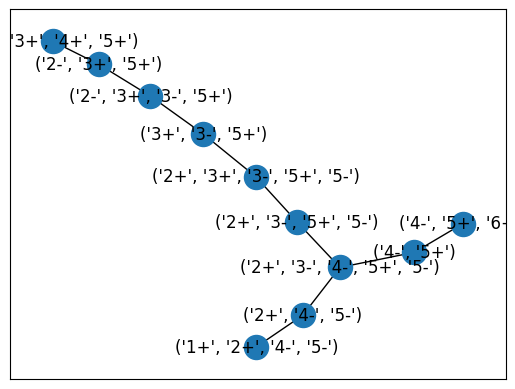

In [ ]:
nx.draw_networkx(nx.junction_tree(nGraph))

In [ ]:
q,w = nx.summarization.dedensify(nGraph,2)

In [ ]:
list(q.edges)

[('1+', '2+'),
 ('2+', '3+'),
 ('2+', '4+'),
 ('3+', '4+'),
 ('4+', '5+'),
 ('4+', '2+')]

In [ ]:
nGraph.add_edge('4+','2+')

In [ ]:
nGraph.remove_edge('4+','2+')

In [ ]:
list(nx.algorithms.components.strongly_connected.strongly_connected_components(nGraph))

[{'5+'}, {'2+', '3+', '4+'}, {'1+'}]

In [ ]:
list(nx.algorithms.simple_cycles(nGraph))

[['3+', '4+', '2+'], ['2+', '4+']]

In [ ]:
paths,cost = nx.algorithms.optimal_edit_paths(nGraph,idealGraph)

In [ ]:
len(paths)

7

In [ ]:
paths[0][1]

[(('1+', '2+'), None),
 (('1+', '4-'), None),
 (('2+', '3+'), ('1+', '2+')),
 (('2-', '5+'), None),
 (('3+', '4+'), None),
 (('4+', '5+'), None),
 (('3+', '5-'), ('2+', '3+')),
 (('5-', '4-'), ('3+', '4+')),
 (('4-', '3-'), ('4+', '5+')),
 (('3-', '2-'), ('5+', '6+')),
 (('4-', '6+'), None),
 (('5+', '6+'), None)]

# Converting path files to graphs

In [ ]:
convertPathsToGraph('../../Meetings/1001G+_20220518/paths.txt',doSorting=True)

In [ ]:
reprocess = False

for filepath in glob.glob(f'{fileDir}{os.path.sep}*.txt'):
    filebase = os.path.splitext(filepath)[0]
    if not os.path.exists(f'{filebase}.gfa') or reprocess:
        print(f'processing {os.path.basename(filebase)}')
        convertPathsToGraph(filepath,doSorting='nodesort')

processing inversion_test_12
Calculating nodes length...
Processing node 8/8
Finished calculating nodes lengths
Preprocessing paths...
Processing path 2/2
Finished preprocessing paths

processing inversion_test_11
Calculating nodes length...
Processing node 8/8
Finished calculating nodes lengths
Preprocessing paths...
Processing path 2/2
Finished preprocessing paths



# Developing/Testing new processing methods

## Functions

- Convert GenomeGraph to NetworkX graph (When?)
- Identify all + -> - points (do we need to do the same for all valid - -> + separately? No! It should be taken care inside inversion blocks, if any left unattended, then they should be precessed separately.)
- (p) Process each such point (do not forget that there can be several paths within onemajor block and all of them should be considered).
- (p) isolate each reversible block and do the reversion (applied to the original graph or to NetworkX graph?)
    - Если при обходе инверсии номер узла увеличивается, то все между предыдущим (или первым) и нынешним добавляются в search terms. Если же номер узла уменьшается, то те номера между предыдущим и нынешним которые уже есть в поисковой группе убираются, а те, которых нет, добавляются.


- Identify loops
- (p) For each loop identify best link to break and remove it from the graph
- (p) Identify type of loop and process it accordingly (real loops - recorded and processed, continuous virtual loops - link for pairing, non-continuous link - consider loop ending at the loop link end).

- Identify bubble ends
- (p) Process each bubble
- Record pairs and double pairs if any.


In [ ]:
def identifyPotentialInvStarts(graph):
    '''
    Identify all + -> - points or - nodes as start nodes in the graph.
    
    We do not need to do the same for all - -> + separately. 
    It should be taken care inside inversion blocks, if any left unattended, 
    then they should be precessed separately.
    
    The function also identify all graph end nodes (the nodes which do not have any outgoing links)
    
    '''
    graphEnds = []
    invStartPoints = []

    for fromNode,nodeLinks in graph:
        if len(nodeLinks)==0:
            graphEnds.append(fromNode)

        if '-' in nodeLinks:
            # The node is passed in inverted direction.
            incomingLinks = graph.backLinks[fromNode]['-']
            if len(incomingLinks)>0:
                # There are links coming towards the inverted version of the node.
                for incomingNode,incomingDir in incomingLinks:
                    if incomingDir=='+':
                        # If there is any edge coming to inverted node comes from positive node, then add it
                        # to the list of potential inversion starts.
                        invStartPoints.append((incomingNode,fromNode))
            else:
                # If there is a inverted node without incoming edge, then it is the start of at least one path
                # It should also be considered as the potential inverstion start
                invStartPoints.append(None,fromNode)
                
    return invStartPoints,graphEnds

### Convert GenomeGraph to 

### Block processing

### Link processing

### Rearrangement blocks

### Wrapper

## Running

In [ ]:
notebook2script()

Converted 00_init.ipynb.
Converted 01_graph.ipynb.
Converted 02_tree.ipynb.
Converted 03_synteny.ipynb.
Converted 04_utils.ipynb.
Converted 05_export.ipynb.
Converted 05_exportDev.ipynb.
Converted deBruijnGraphProcessing.ipynb.
Converted dev.ipynb.
Converted graphTesting.ipynb.
Converted index.ipynb.


In [ ]:
sorted(glob.glob(f'{fileDir}{os.path.sep}*.gfa'))

['../../1001G/GraphCollapsing/TestGraphs/inversion_test_01.gfa',
 '../../1001G/GraphCollapsing/TestGraphs/inversion_test_02.gfa',
 '../../1001G/GraphCollapsing/TestGraphs/inversion_test_03.gfa',
 '../../1001G/GraphCollapsing/TestGraphs/inversion_test_04.gfa',
 '../../1001G/GraphCollapsing/TestGraphs/inversion_test_05.gfa',
 '../../1001G/GraphCollapsing/TestGraphs/inversion_test_06.gfa',
 '../../1001G/GraphCollapsing/TestGraphs/inversion_test_07.gfa',
 '../../1001G/GraphCollapsing/TestGraphs/inversion_test_08.gfa',
 '../../1001G/GraphCollapsing/TestGraphs/inversion_test_09.gfa',
 '../../1001G/GraphCollapsing/TestGraphs/inversion_test_10.gfa',
 '../../1001G/GraphCollapsing/TestGraphs/repeats_test_01.gfa',
 '../../1001G/GraphCollapsing/TestGraphs/repeats_test_02.gfa',
 '../../1001G/GraphCollapsing/TestGraphs/repeats_test_03.gfa',
 '../../1001G/GraphCollapsing/TestGraphs/repeats_test_04.gfa',
 '../../1001G/GraphCollapsing/TestGraphs/repeats_test_05.gfa',
 '../../1001G/GraphCollapsing/TestG

In [ ]:
filename = 'inversion_test_01.gfa'
inversionThreshold=0.5

In [ ]:
graph = GenomeGraph(gfaPath=f'{fileDir}{os.path.sep}{filename}',isGFASeq=False, doBack=True)

Loading graph from ../../1001G/GraphCollapsing/TestGraphs/inversion_test_01.gfa
Found node annotation file ../../1001G/GraphCollapsing/TestGraphs/annotation_inversion_test_01.dat, loading associations.
Loading segment 6/6
Loading segments finished.
Loading link 12/12
Loading links finished
Loading path 3/3
Loading paths finished. 3 paths added, 0 paths ignored.
Calculating nodes length...
Processing node 6/6
Finished calculating nodes lengths
Preprocessing paths...
Processing path 3/3
Finished preprocessing paths



In [ ]:
graph.paths

[['1+', '2+', '3+', '4-', '5+', '6+'],
 ['1+', '2-', '3+', '4+', '5+', '6+'],
 ['1+', '2+', '3+', '5-', '4+', '6+']]

In [ ]:
invStartPoints,graphEnds = identifyPotentialInvStarts(graph)

In [ ]:
graphEnds

[6]

In [ ]:
invStartPoints

[(1, 2), (3, 4), (3, 5)]

We follow links by the following rules:
- The initiation link is `a+ -> b-`. We get all nodes between `a` and `b` (exclusive) as search nodes.
- Node `b` is added to the inversion stretch list.
- Next node is either inverted node (irrespective of current search nodes) on normal node which is in current search nodes list. If there are several options, each option should be considered. Done through a special queue for each step.
- (*) If node `c+` is found to be added to the stretch, and it is returning node, i.e. lets call max(search terms) as`d` and min(search terms) as `e`:
        - if `c<d` and `c<b` (the link to it goes to the left), then flip (meaning that if a node is in search terms, then remove it, otherwise, add it) in search terms all nodes between c and d (inclusive).
        - if `c>e` and `c>b` (the link to it goes to the right), then flip (meaning that if a node is in search terms, then remove it, otherwise, add it) in search terms all nodes between e and c (inclusive).
- If we come through `x+ -> y-` in the stretch, it should be removed from initiation links list (possibly, each of them should be processed separately, but after that the stretches from initiation links that were used in other stretched should be removed.
- If in (*) all search terms are wiped, then `c+` will be the end edge of the stretch and stretch closed.
- If there is no more options of either inverted node, or normal node from search nodes linked from current one, then this particular stretch is finished. In this case, the next closest normal node (not in the stretch, i.e. not in `min:max+1`) linked from current one is the right end of the stretch.

In [ ]:
processingQueue = []

inversionBlocks = []
for invStart in invStartPoints:
    blockStart = invStart[0]
    block = []
    blockEnd = None
    
    firstNode = min(invStart)
    lastNode = max(invStart)
    searchNodes = set(range(firstNode+1,lastNode))
    
    curNode,curDir = invStart[1],'-'
    
    while blockEnd is None:
        nextNodes = graph.forwardLinks[curNode]['curDir']
        pass
    
    
    print(searchNodes)

[]
[]
[4]
